# **Leather Defect detection and Classification**

In recent years, modern tanning industries have increasingly focused on the production of high-quality leather goods in order to remain competitive in the global market. However, during the different stages of the production process, such as material handling, tanning, and dyeing, numerous surface defects may arise. Among the most common are folding marks, grain off, growth marks, loose grains, and pinhole defects.

Manual inspection of leather surfaces is often subjective, inconsistent, and highly dependent on the operator’s experience. Moreover, many defects exhibit ambiguous patterns and extremely subtle characteristics, sometimes difficult to distinguish with the naked eye. For this reason, machine vision systems now represent a strategic solution for automating quality control, ensuring greater objectivity, repeatability, and efficiency.

# **Project Goals**

The primary objective of this project is to design, implement, and compare two different deep learning approaches for the multiclass classification of leather surface defects.

# **Dataset description**

We use the Leather Defect Classification dataset (https://www.kaggle.com/datasets/praveen2084/leather-defect-classification), which contains images of leather surfaces annotated according to the presence and type of defect.

The six classes considered are:

* Folding marks
* Grain off
* Growth marks
* Loose grains
* Non defective
* Pinhole

Each class consists of 600 images, for a total of 3,600 observations.

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    os.chdir(path_MG)
    print(f"Working in MG's folder: {path_MG}")
elif os.path.exists(path_LM):
    os.chdir(path_LM)
    print(f"Working in LM's folder: {path_LM}")

base_dir = 'dataset'
if os.path.exists(base_dir):
    print("Dataset found!")
else:
    print("Error: Dataset not found. Check the path.")

Mounted at /content/drive
Working in Matteo's folder: /content/drive/MyDrive/00gerem00/DL-AI-Project
Dataset found!


In [2]:
from torchvision.datasets import ImageFolder

content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

print(f"Data path identified: {data_dir}")

dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Dataset successfully connected!")
print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")

print(f"Index mapping: {dataset.class_to_idx}")

Data path identified: dataset/Leather Defect Classification
Dataset successfully connected!
Total number of images: 3598
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [3]:
from collections import Counter

size_counter = Counter()
color_modes = set()

for image, label in dataset:

    size_counter[image.size] += 1
    color_modes.add(image.mode)

print("\nSize Report:")
for size, count in size_counter.items():
    print(f" - {size[0]}x{size[1]} pixel: {count} images")

print(f"\nColor Mode: {color_modes}")



Size Report:
 - 227x227 pixel: 3598 images

Color Mode: {'RGB'}


# **1. Exploratory Data Analysis**

Before proceeding with model training, a preliminary data quality check was performed, with particular attention to the dimensional consistency of the images.

Specifically, a script was implemented to:

* recursively scan all dataset directories;

* open each image file;

* check its width and height in pixels;

* identify as potential outliers any images whose dimensions exceed a predefined threshold (500 pixels per side).

The purpose of this verification step is to:

* detect possible anomalies within the dataset (e.g., incorrectly resized images or files originating from different sources);

* prevent potential issues during preprocessing and training;

* ensure structural consistency across all model inputs.

Images exceeding the threshold are considered dimensional outliers. This verification process ensures that the dataset is homogeneous before applying the standard preprocessing pipeline (resizing, normalization, data augmentation) required for model training.

The analysis revealed the following distribution of image sizes:

* 227 × 227 pixels: 3598 images

* 4608 × 3288 pixels: 2 images

All images were encoded in RGB color mode, with no grayscale or alternative color formats detected:

* Color Mode: {'RGB'}

In [5]:
from PIL import Image

threshold_px_dim = 500

print("Starting outlier removal procedure...")

removed = 0

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)

            with Image.open(full_path) as img:
              width, height = img.size

              if width > threshold_px_dim or height > threshold_px_dim:
                print(f"Outlier detected: {file} ({width}x{height})")
                img.close()

                os.remove(path_completo)
                print(f" -> File permanently deleted: {full_path}")
                removed += 1

print(f"\nProcedure completed. Total files removed: {removed}")

dataset = ImageFolder(
    root = data_dir,
    transform = None)
print("Number of images in the dataset after cleaning:", len(dataset))


Starting outlier removal procedure...

Procedure completed. Total files removed: 0
Number of images in the dataset after cleaning: 3598


The inspection shows that the dataset is highly consistent, with 3598 images already matching the expected resolution of 227 × 227 pixels. However, two images were identified as dimensional outliers, exhibiting significantly higher resolution (4608 × 3288 pixels).

These two images were likely generated through a different acquisition or preprocessing procedure and were therefore not aligned with the standardized dataset format. To preserve dataset homogeneity and avoid introducing unintended variability during training, we decided to remove these two outlier images from the dataset.

This decision ensures that:

* all training samples share identical spatial dimensions;

* the preprocessing pipeline operates under fully controlled conditions;

* the comparison between the baseline CNN classifier and the autoencoder-based model is not affected by structural inconsistencies.

After removing the two outliers, the final dataset consists of 3598 RGB images, all with resolution 227 × 227 pixels, providing a clean and consistent input space for both models.

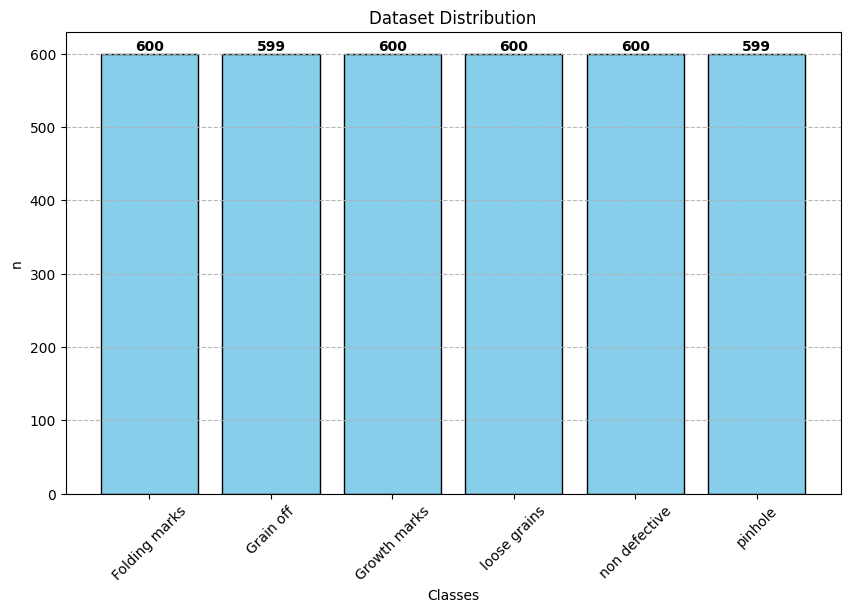

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Estrazione delle etichette (targets) dal dataset
# dataset.targets restituisce una lista di indici (es. [0, 0, 1, 2, ...])
labels = dataset.targets
counts = Counter(labels)

# Mappatura da indice numerico a nome della classe
class_names = dataset.classes
distribution = {class_names[idx]: count for idx, count in counts.items()}

# Generazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(distribution.keys(), distribution.values(), color='skyblue', edgecolor='black')
plt.xlabel('Classes')
plt.ylabel('n')
plt.title('Dataset Distribution')
plt.xticks(rotation = 45) # Rotazione etichette per leggibilità
plt.grid(axis = 'y', linestyle = '--', alpha = 0.9)

# Aggiunta del valore sopra ogni barra
for i, v in enumerate(distribution.values()):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

The final dataset distribution is shown in the figure above. After removing two dimensional outliers, the dataset contains 3598 images in total. Each of the six classes remains almost perfectly balanced, with four classes containing 600 images and two classes containing 599 images.

This minimal difference does not introduce any relevant class imbalance and therefore does not require additional resampling or weighting strategies. The dataset can be considered effectively balanced for training and evaluation purposes.

# **1.1 Qualitative Inspection of Sample Images**

 We display a random sample of size 9 of images in order to show what the dataset looks like.

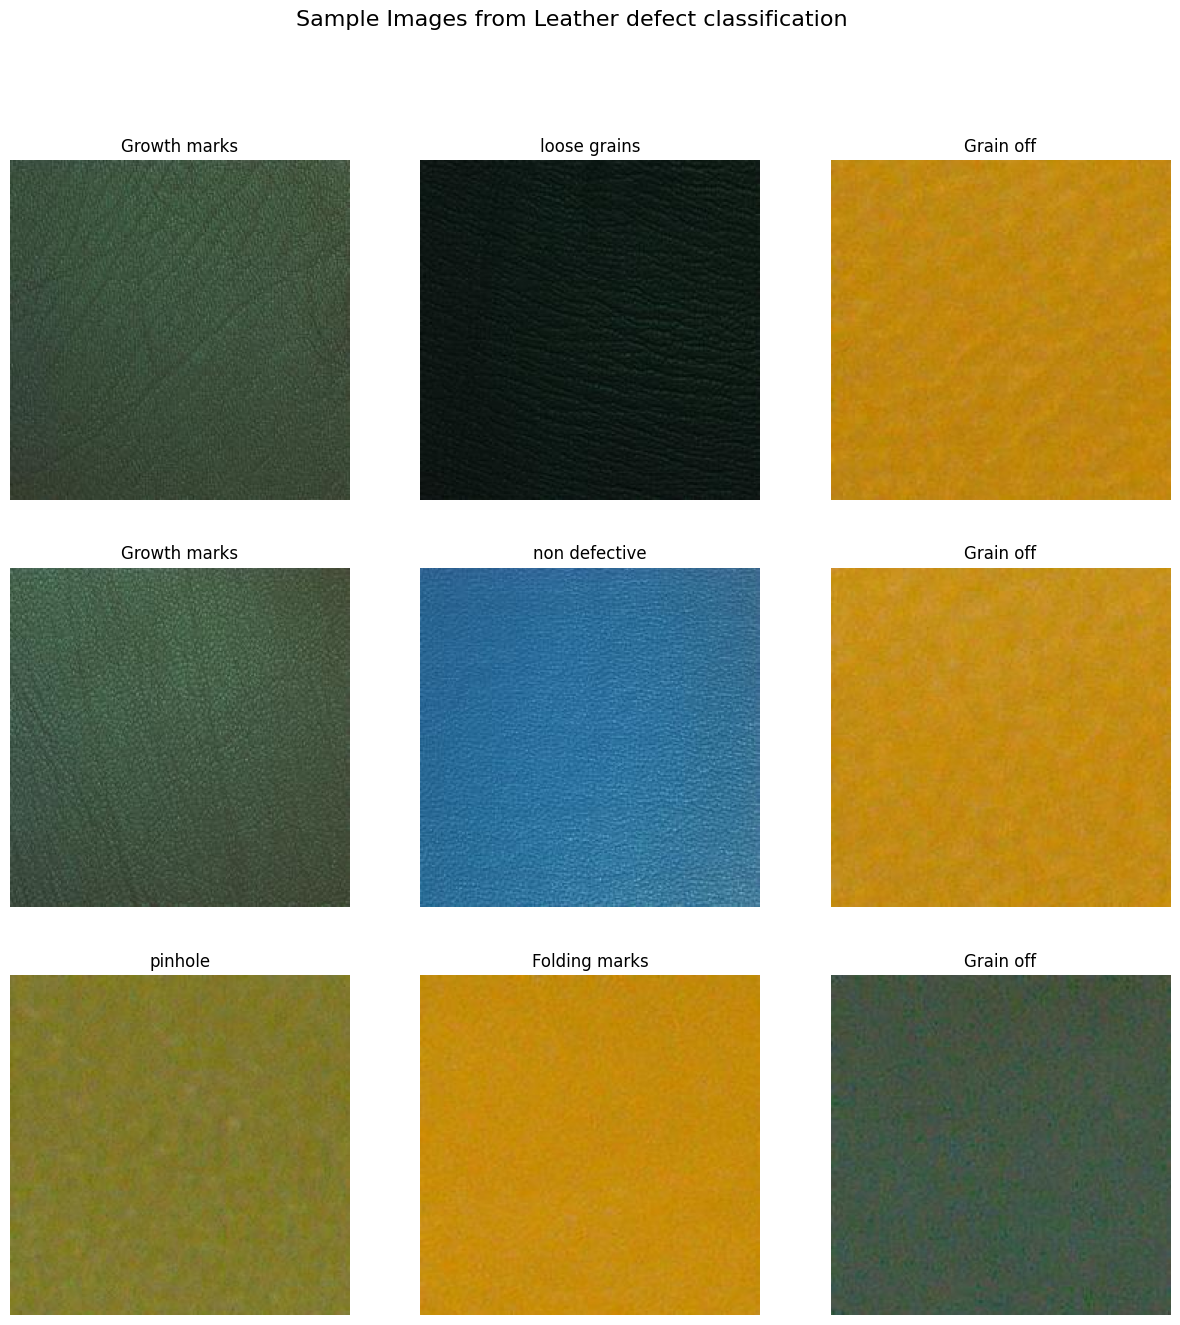

In [ ]:
import random

plt.figure(figsize = (15, 15))

for i in range(9):
  idx = random.randint(0, len(dataset) - 1)
  img, label = dataset[idx]

  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(dataset.classes[label])
  plt.axis("off")

plt.suptitle("Sample Images from Leather defect classification", fontsize = 16)
plt.show()

The figure shows randomly selected sample images from the dataset. A visual inspection indicates that the classification problem is primarily texture-based. The different classes exhibit subtle variations in surface patterns and structural irregularities, while color differences are not consistently associated with specific defect categories.

# **1.2 Edge detection** (da capire se mettere o troppo sbatti)

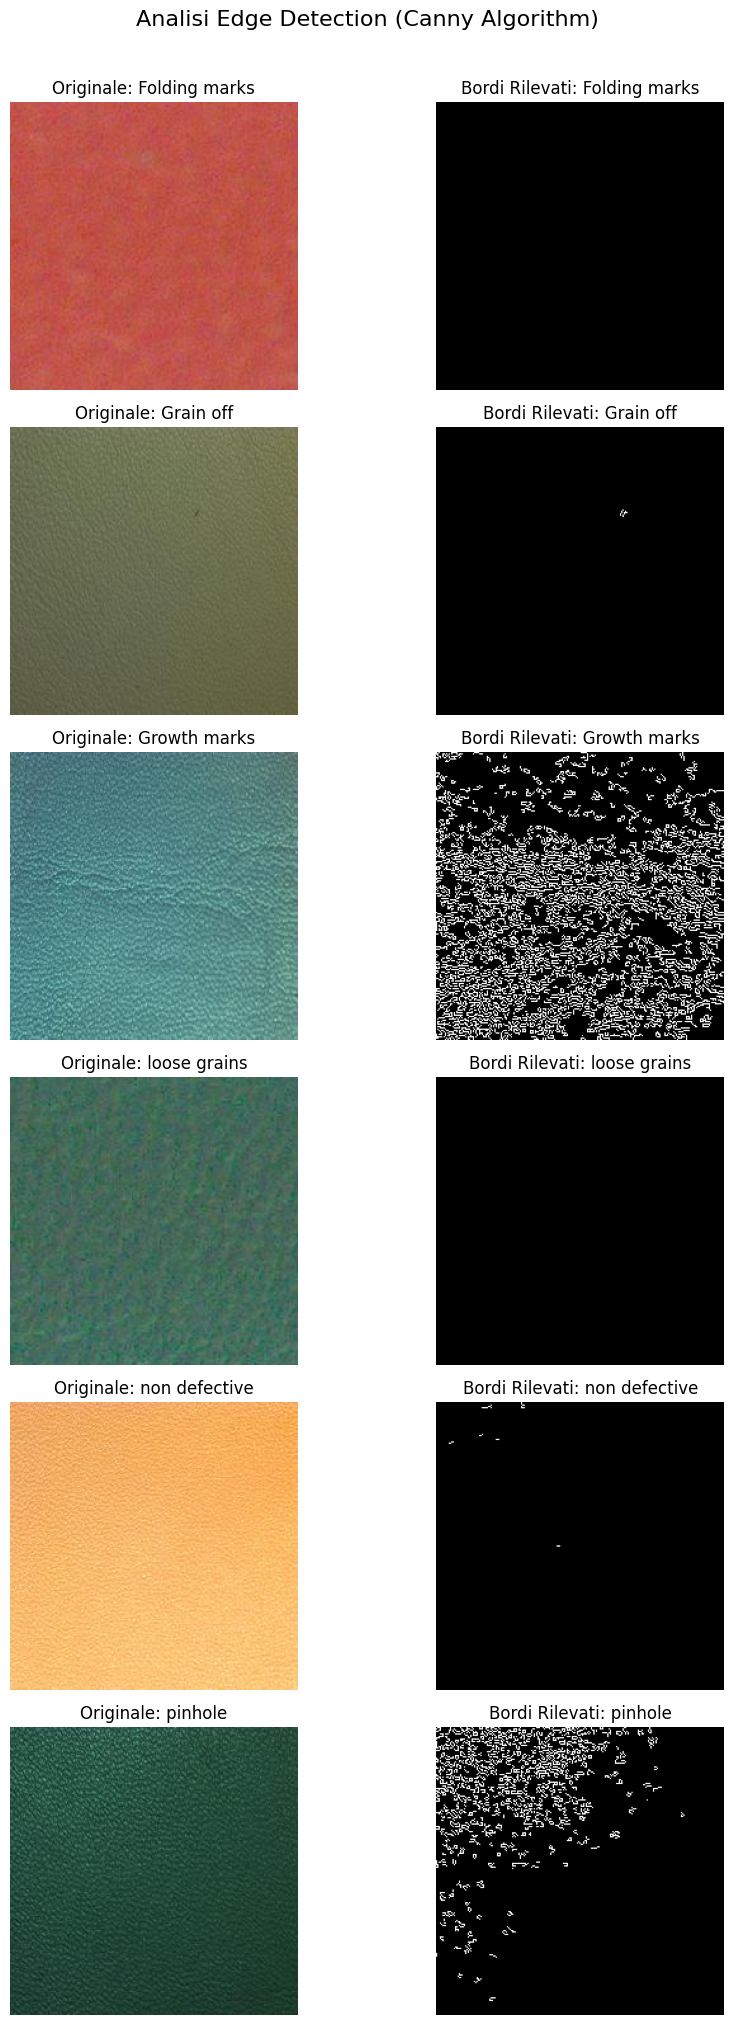

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 1. Selezione casuale di un'immagine per ogni classe
# Raggruppiamo gli indici per classe
indices_per_class = defaultdict(list)
for idx, label in enumerate(dataset.targets):
    indices_per_class[label].append(idx)

# Dizionario per salvare le immagini selezionate
selected_samples = {}

for label in sorted(indices_per_class.keys()):
    # Selezione casuale di un indice
    random_idx = random.choice(indices_per_class[label])
    img, _ = dataset[random_idx] # img è un oggetto PIL
    selected_samples[label] = img

# 2. Configurazione del grafico
# Creiamo una griglia con 6 righe (una per classe) e 2 colonne (Originale, Edges)
fig, axes = plt.subplots(len(dataset.classes), 2, figsize=(10, 20))
fig.suptitle("Analisi Edge Detection (Canny Algorithm)", fontsize=16, y=1.01)

# 3. Elaborazione e Visualizzazione
for i, label in enumerate(sorted(selected_samples.keys())):
    pil_image = selected_samples[label]
    class_name = dataset.classes[label]

    # Conversione da PIL a NumPy array per OpenCV
    img_np = np.array(pil_image)

    # Conversione in scala di grigi (necessaria per Edge Detection)
    # Nota: PIL usa RGB, OpenCV converte correttamente
    gray_image = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Applicazione Canny Edge Detector
    # Parametri: soglia minima (100) e massima (200) per l'isteresi
    edges = cv2.Canny(gray_image, 100, 200)

    # Colonna 1: Immagine Originale
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Originale: {class_name}")
    axes[i, 0].axis('off')

    # Colonna 2: Edge Detection
    axes[i, 1].imshow(edges, cmap='gray')
    axes[i, 1].set_title(f"Bordi Rilevati: {class_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

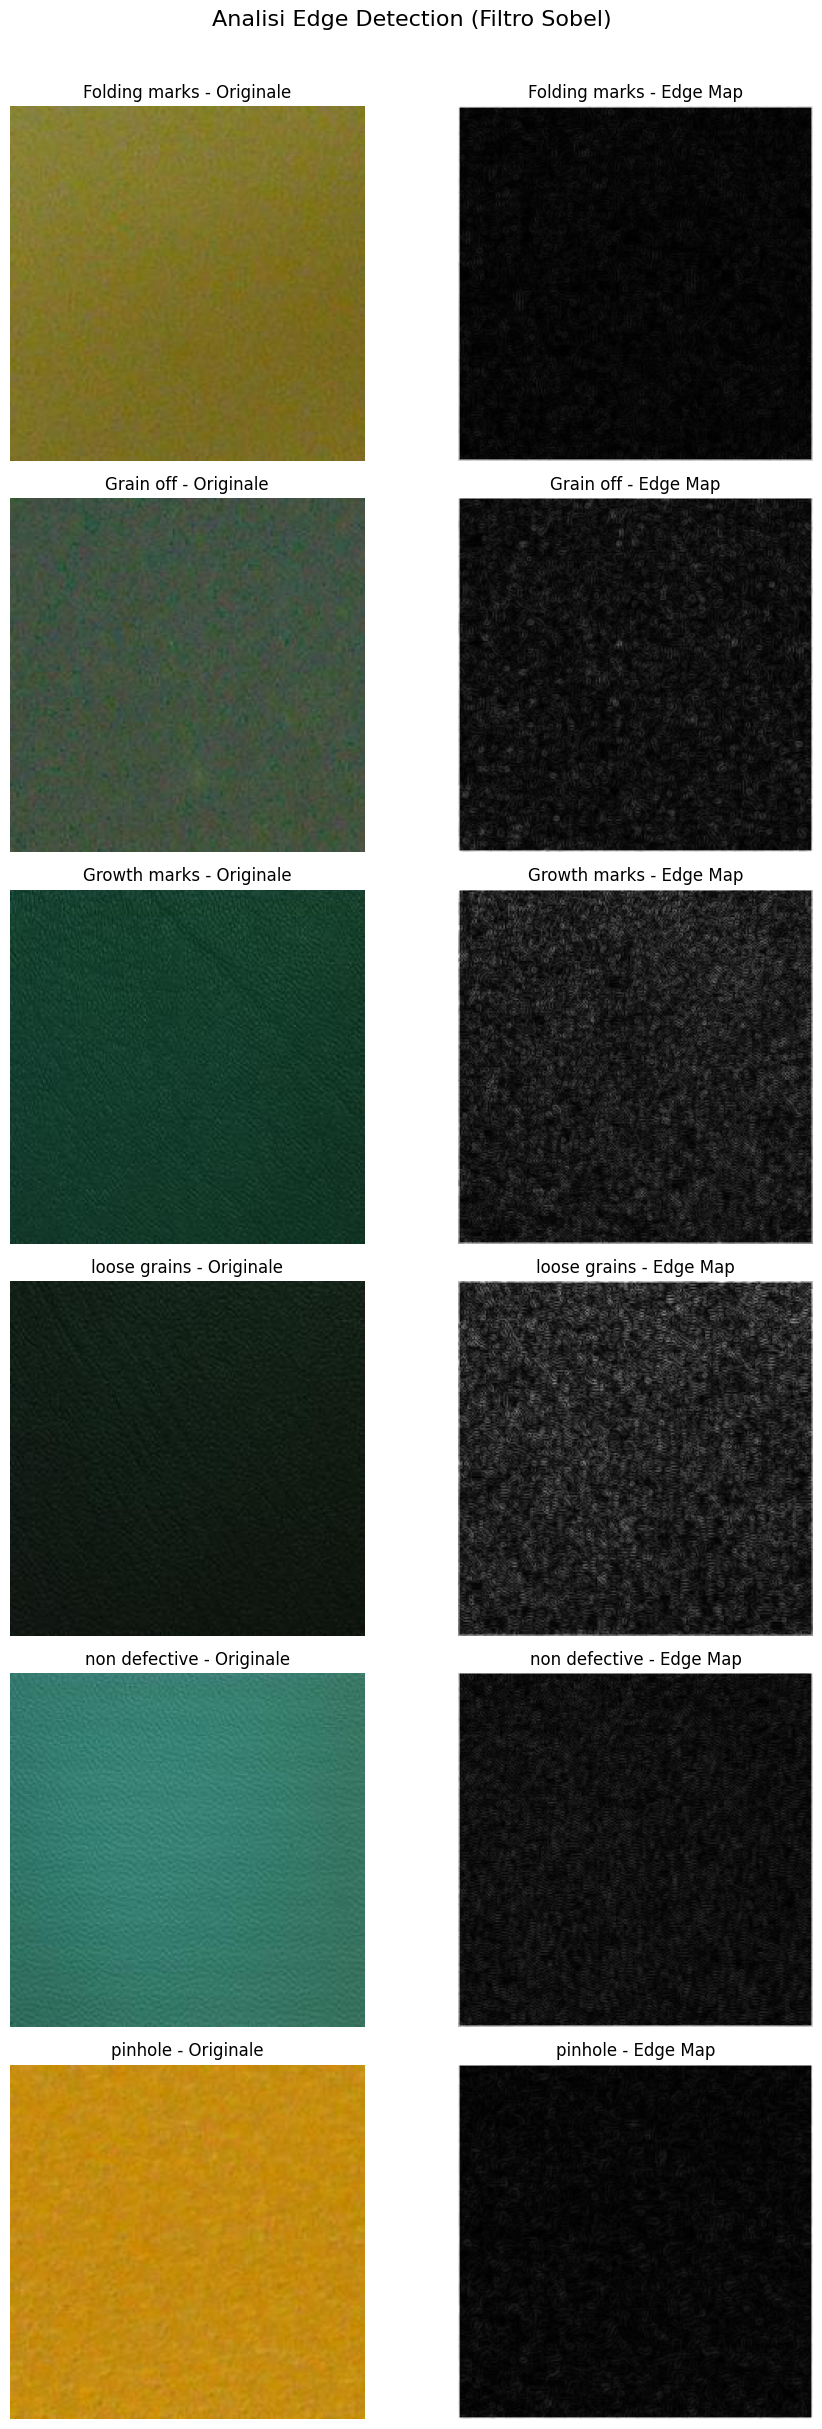

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from collections import defaultdict

# 1. Definizione della funzione di Edge Detection (Filtro di Sobel)
def apply_sobel_edge_detection(img_tensor):
    """
    Applica il filtro di Sobel a un tensore immagine (C, H, W).
    Restituisce la magnitudo del gradiente.
    """
    # Conversione in scala di grigi se l'immagine è RGB (3 canali)
    if img_tensor.shape[0] == 3:
        weights = torch.tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
        img_gray = (img_tensor * weights).sum(dim=0, keepdim=True)
    else:
        img_gray = img_tensor

    # Aggiunta dimensione batch: da (1, H, W) a (1, 1, H, W)
    img_gray = img_gray.unsqueeze(0)

    # Definizione Kernel Sobel X (Rileva bordi verticali)
    kx = torch.tensor([[-1.0, 0.0, 1.0],
                       [-2.0, 0.0, 2.0],
                       [-1.0, 0.0, 1.0]]).view(1, 1, 3, 3)

    # Definizione Kernel Sobel Y (Rileva bordi orizzontali)
    ky = torch.tensor([[-1.0, -2.0, -1.0],
                       [0.0, 0.0, 0.0],
                       [1.0, 2.0, 1.0]]).view(1, 1, 3, 3)

    # Applicazione della convoluzione
    gx = F.conv2d(img_gray, kx, padding=1)
    gy = F.conv2d(img_gray, ky, padding=1)

    # Calcolo della magnitudo del gradiente
    edges = torch.sqrt(gx**2 + gy**2)

    return edges.squeeze()

# 2. Selezione di un'immagine casuale per ogni classe
indices_per_class = defaultdict(list)
# Verifica che dataset.targets sia accessibile, altrimenti usa un ciclo manuale
try:
    targets = dataset.targets
except AttributeError:
    targets = [label for _, label in dataset]

for idx, label in enumerate(targets):
    indices_per_class[label].append(idx)

selected_images = {}
for label in sorted(indices_per_class.keys()):
    random_idx = random.choice(indices_per_class[label])
    img, _ = dataset[random_idx]
    selected_images[label] = img

# 3. Visualizzazione (Originale vs Edge Detection)
num_classes = len(selected_images)
fig, axes = plt.subplots(num_classes, 2, figsize=(10, 4 * num_classes))
fig.suptitle("Analisi Edge Detection (Filtro Sobel)", fontsize=16, y=1.01)

converter = transforms.ToTensor()

for idx, label in enumerate(sorted(selected_images.keys())):
    # Immagine originale (PIL)
    original_img_pil = selected_images[label]
    label_name = dataset.classes[label]

    # Conversione in Tensore SOLO per il calcolo
    img_tensor = converter(original_img_pil)

    # Applicazione del filtro
    edges_img = apply_sobel_edge_detection(img_tensor)

    # Plot Immagine Originale (Matplotlib gestisce PIL nativamente)
    ax_orig = axes[idx, 0]
    ax_orig.imshow(original_img_pil)
    ax_orig.set_title(f"{label_name} - Originale")
    ax_orig.axis('off')

    # Plot Edge Detection (Tensore)
    ax_edge = axes[idx, 1]
    ax_edge.imshow(edges_img, cmap='gray')
    ax_edge.set_title(f"{label_name} - Edge Map")
    ax_edge.axis('off')

plt.tight_layout()
plt.show()